In [1]:
"""
sudo pip2 install opencv-python
sudo pip3 install opencv-python

sudo pip2 install opencv-contrib-python
sudo pip3 install opencv-contrib-python
"""

'\nsudo pip2 install opencv-python\nsudo pip3 install opencv-python\n\nsudo pip2 install opencv-contrib-python\nsudo pip3 install opencv-contrib-python\n'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
########## a simple corner detection ################

In [4]:
filename = 'Chessboard.png'
img = cv2.imread(filename)

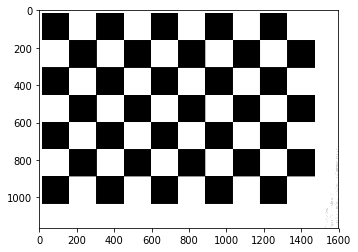

In [5]:
plt.imshow(img)

In [6]:
np.shape(img)

(1163, 1600, 3)

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Converte da rgb a grigio

In [8]:
gray.dtype

dtype('uint8')

In [9]:
gray = np.float32(gray)

In [ ]:
gray.dtype

In [ ]:
dst = cv2.cornerHarris(gray,2,3,0.04)

In [ ]:
dst

In [ ]:
plt.imshow(dst, interpolation="nearest", cmap="gray")

In [ ]:
kernel = np.ones((7,7),np.uint8)
#Definisco kernel unitario con dimensioni 7x7

In [ ]:
dst = cv2.dilate(dst,kernel,iterations=2)

In [ ]:
plt.imshow(dst,cmap="gray")

In [ ]:
dst.max()

In [ ]:
img[dst>0.01]=[255,0,0]

#tutti gli elementi superiori ad una certa soglia ponili a 255,0,0
#che in rgb diventano rosse

In [ ]:
plt.imshow(img)

In [ ]:
############ a simple sift detector #############

In [ ]:
img = cv2.imread('home.jpg')
img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#si passa dallo standard BGR a RGB
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(gray,cmap="gray")

In [ ]:
def init_feature(name):
    #Si definisce una funzione alla quale passo una famiglia di feature. 
    #Si crea l'oggetto detettore per quella determinata famiglia.

    detector = None
    norm = None
    matcher = None

    FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
    FLANN_INDEX_LSH = 6
    chunks = name.split('-')
    if chunks[0] == 'sift':
        detector = cv2.xfeatures2d.SIFT_create()
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(800)
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(400)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        return None, None


    if 'flann' in chunks:
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:
            flann_params = dict(algorithm=FLANN_INDEX_LSH,
                                table_number=6,  # 12
                                key_size=12,  # 20
                                multi_probe_level=1)  # 2
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
    else:
        matcher = cv2.BFMatcher(norm)
    return detector, matcher

In [ ]:
detector_matcher = 'sift-flann'
#detector_matcher = 'orb-flann'
#detector_matcher = 'akaze-flann'
#detector_matcher = 'brisk-flann'

In [ ]:
detector,matcher = init_feature(detector_matcher)

In [ ]:
kp, desc = detector.detectAndCompute(gray, None)

In [ ]:
kp[0].pt

In [ ]:
kp[0].size

In [ ]:
kp[0].angle

In [ ]:
kp[0].response

In [ ]:
im_annotated = np.zeros_like(gray)

In [ ]:
im_annotated = cv2.drawKeypoints(gray,kp,im_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
plt.imshow(im_annotated)

In [ ]:
#####   matching features   ######

In [ ]:
img1 = cv2.imread('template.jpg')
img2 = cv2.imread('scenario.jpg')

In [ ]:
img1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(img1,cmap="gray")

In [ ]:
plt.imshow(img2,cmap="gray")

In [ ]:
kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)

In [ ]:
img1_annotated = np.zeros_like(img1)
img2_annotated = np.zeros_like(img2)

In [ ]:
img1_annotated = cv2.drawKeypoints(img1,kp1,img1_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_annotated = cv2.drawKeypoints(img2,kp2,img2_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
plt.imshow(img1_annotated)

In [ ]:
plt.imshow(img2_annotated)

In [ ]:
raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)
#vado a trovare le features delle due immagini che combaciano per identificare il libro

In [ ]:
np.size(raw_matches)

In [ ]:
def filter_matches(kp1, kp2, matches, ratio=0.75):

    mkp1, mkp2 = [], []


    m = []

    for m in matches:

        if len(m) == 2 and m[0].distance < m[1].distance * ratio:

            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])


    #if debug_mode:print("appended keypoints")
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, kp_pairs

In [ ]:
q, a, kp_pairs = filter_matches(kp1, kp2, raw_matches)

In [ ]:
np.shape(kp_pairs)

In [ ]:
H, status = cv2.findHomography(q,a,cv2.RANSAC,5.0)

In [ ]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)

In [ ]:
vis[:h1, :w1] = img1

In [ ]:
vis[:h2, w1:w1 + w2] = img2

In [ ]:
plt.imshow(vis,cmap="gray")

In [ ]:
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

In [ ]:
green = (0, 255, 0)
red = (0, 0, 255)

In [ ]:
p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)

In [ ]:
corners_starting = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
corners_ending = np.int32(cv2.perspectiveTransform(corners_starting.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0))
vis = cv2.polylines(vis, [corners_ending], True, (255, 0, 0),6)

In [ ]:
for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        cv2.line(vis, (x1, y1), (x2, y2), green)

In [ ]:
plt.imshow(vis)